In [1]:
!pwd

/global/u1/l/lzshi01/mydev/rsna/notebook


In [2]:
!which python

/global/common/cori_cle7/software/jupyter/cori/20-09/bin/python


In [3]:
!python --version

Python 3.8.3


In [4]:
import os,sys

In [5]:
os.chdir("..")
!pwd

/global/u1/l/lzshi01/mydev/rsna


In [6]:
import pydicom
import zipfile
import  tarfile
import io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
filepath='input/train/ab81e884410e.tar.gz'

In [18]:
def read_tar(filepath):
    slices=[]
    with tarfile.open(filepath) as tar:
        for member in tar.getmembers():
            if member.isfile() and member.name.endswith(".dcm"):
                f=tar.extractfile(member)
                img=pydicom.dcmread(f)
                slices.append( (member.name, img) )
    
    slices=sorted(slices,key=lambda u: int(u[1].SeriesNumber))
                              
    return slices

In [19]:
slices=read_tar(filepath)
len(slices)

228

In [10]:
def dicom_to_img(dcm):
    raw_pixelarrays = dcm.pixel_array
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    img = raw_pixelarrays * dcm.RescaleSlope + dcm.RescaleIntercept
    return img
    

In [59]:
#img=dicom_to_img(slices['ab81e884410e/866f5034ca38/3d690f5b18ec.dcm'])
img=dicom_to_img(slices[len(slices)//5][1])

In [60]:
plt.imshow(img,cmap='gray')

In [38]:
def thresholding(img, width,level):
    hw=width//2
    newimg=img.copy()
    low=level-hw
    high=level+hw
    newimg[img>high]=high
    newimg[img<low]=low
    newimg = (newimg-low)/(width)*255
    return newimg.astype(np.uint8)
    

In [39]:
plt.hist(img.reshape(-1));

In [40]:
img.min(),img.max()

(-1024.0, 3071.0)

In [41]:
!pip install opencv-python --user

In [42]:
import cv2
def refine_input(im_th):
    cnts, hir = cv2.findContours(im_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas = [cv2.contourArea(cnt) for cnt in cnts] 
    if len(areas) == 0: return im_th
    i = np.argsort(areas)[-1]
    cnt = cnts[i]
    a = np.zeros([*im_th.shape, 3], dtype=np.uint8)
    cv2.drawContours(a, cnts, i, (255, 255, 255), thickness=cv2.FILLED);
    mask = (a[:, :, 0] > 0).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.dilate(mask, kernel, iterations=20)    
    return (mask > 0) * im_th

def refine_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.dilate(mask, kernel, iterations=20)

    cnts, hir = cv2.findContours(255 - mask * 255, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas = [cv2.contourArea(cnt) for cnt in cnts] 
    if len(areas) == 0: return mask
    # if len(areas)==0: return mask*0
    i = np.argsort(areas)[-1]
    cnt = cnts[i]
    a = np.zeros([*mask.shape, 3], dtype=np.uint8)
    cv2.drawContours(a, cnts, i, (255, 255, 255), thickness=cv2.FILLED);
    return a[:, :, 0]


def flushing(im_th, b_show=False):
    im_th = refine_input(im_th)
    im_floodfill = im_th.astype(np.uint8).copy() 
    h, w = im_th.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255);
    cv2.floodFill(im_floodfill, mask, (w - 1, 0), 255);
    cv2.floodFill(im_floodfill, mask, (0, h - 1), 255);
    cv2.floodFill(im_floodfill, mask, (w - 1, h - 1), 255);
    mask = refine_mask(mask)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    mask = mask[1:-1, 1:-1]
    im_out = mask * im_floodfill_inv
    if b_show:
        import matplotlib.pyplot as plt
        plt.subplot(2, 2, 1)
        plt.imshow(im_th, cmap='gray')  
        plt.axis('off')
        plt.title("orignal")
        plt.subplot(2, 2, 2)
        plt.axis('off')
        plt.imshow(mask, cmap='gray')    
        plt.title("mask")
        plt.subplot(2, 2, 3)
        plt.axis('off')
        plt.imshow(im_floodfill, cmap='gray')    
        plt.title("floodfill")
        plt.subplot(2, 2, 4)
        plt.axis('off')
        plt.imshow(im_out, cmap='gray')    
        plt.title("out")
        plt.show()
    return im_out, mask


def th(img, low, high):
    a = img.copy() 
    a[a < low] = low
    a[a > high] = high

    a = (a - low) / (a.max() - a.min() + 1e-7)

    im_th1 = ((a > 0.5) * 255).astype(np.uint8)
    return im_th1

def th3(img, threshold):
    a = img.copy() 
    a[img > threshold] = 1
    a[img <= threshold] = 0
    im_th1 = (a).astype(np.uint8)
    return im_th1


def openning(img):
    kernel = np.ones((5,5),np.uint8)
    if 1:
        dilation = cv2.dilate(img,kernel,iterations = 10)
        return dilation
    else:
        opening = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=30)
        return opening

def phase4_make_lungmask(img, b_show=False):
    im_th1 = th(img, -600, -600 + 1)
    _, mask = flushing(im_th1, b_show)
    img = img * (mask > 0)
    im_th2 = 1 - th3(img, -500)
    im_th2=openning(im_th2)
    return im_th2

def to_cnn_img(img):
    return cv2.resize(img,(224,224))

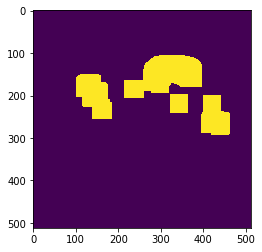

In [61]:
plt.imshow(phase4_make_lungmask(img))

In [44]:
def to_rgb(img,use_mask=True):
    if use_mask:
        mask=phase4_make_lungmask(img)
    else:
        mask=np.ones_like(img,dtype=np.uint8)
    a=thresholding(img,width=1000, level=-750)*mask
    b=thresholding(img,width=400, level=40)*mask
    c=thresholding(img,width=700, level=100)*mask
    return np.array([a,b,c]).transpose([1,2,0])

def slices_to_rgb(slices):
    res={}
    for k,dcm in slices.items():
        img=dicom_to_img(dcm)
        img=to_cnn_img(to_rgb(img,True))
        res[k]=img
    return res
        

In [45]:
import pickle 
import gzip


def pickle_dumpz(obj, filepath):
    with gzip.open(filepath, 'w') as f:
        pickle.dump(obj, f)

        
def pickle_loadz(filepath):
    with gzip.open(filepath, 'r') as f:
        return pickle.load(f)  

In [46]:
images=slices_to_rgb(slices)
len(images)

AttributeError: 'list' object has no attribute 'items'

In [47]:
if 0:
    for k, v in images.items():
        plt.imshow(v);plt.show()

In [289]:
#pickle_dumpz(images, 'b.pklz')

In [280]:
#pickle_dumpz(to_cnn_img(to_rgb(img,True)), 'a.pklz')

-250 -1250
240 -160
450 -250


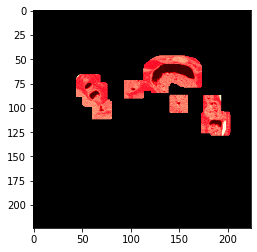

In [63]:
plt.imshow(to_cnn_img(to_rgb(img,True)))

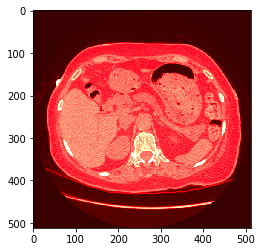

In [62]:
plt.imshow(to_rgb(img,False))

In [255]:
plt.imshow(to_rgb(img))

-250 -1250
240 -160
450 -250


In [50]:
a=thresholding(img,width=1000, level=-750)
plt.imshow(a,cmap='gray')

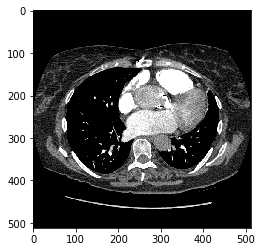

In [51]:
a=thresholding(img,width=400, level=40)
plt.imshow(a,cmap='gray')

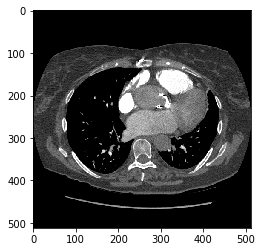

In [52]:
a=thresholding(img,width=700, level=100)
plt.imshow(a,cmap='gray')